In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
# Configuration
forecast_horizon = 5   # Predict 5 days
seq_len = 30           # Use 30 days of history

# -----------------------------
# LSTM Model Definition
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, forecast_horizon, hidden_size=128, num_layers=2, dropout=0.2):
        """
        input_size: Number of features in the input (all features scaled)
        forecast_horizon: Number of days to predict (here, 5)
        """
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, forecast_horizon)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Output shape: (batch, forecast_horizon)

# -----------------------------
# Helper Functions
# -----------------------------
def create_sequences(data, dates, seq_len=30, forecast_horizon=5, target_col_idx=0, stride=1):
    X, y, base_dates, forecast_dates = [], [], [], []
    n = len(data)
    for i in range(0, n - seq_len - forecast_horizon + 1, stride):
        X.append(data[i : i + seq_len])
        y.append(data[i + seq_len : i + seq_len + forecast_horizon, target_col_idx])
        base_dates.append(dates[i + seq_len - 1])
        forecast_dates.append(dates[i + seq_len + forecast_horizon - 1])
    return np.array(X), np.array(y), np.array(base_dates), np.array(forecast_dates)

def inverse_scale_change_predictions(predictions, scaler, target_col_idx=0):
    """
    Inverse transforms the predicted percent change values using StandardScaler.
    The function reshapes predictions to (-1, 1), applies scaler.inverse_transform,
    and then reshapes back to the original shape.
    """
    orig_shape = predictions.shape
    predictions_reshaped = predictions.reshape(-1, 1)
    inv = scaler.inverse_transform(predictions_reshaped)
    return inv.reshape(orig_shape)

def train_model(params, X_train_tensor, y_train_tensor, epochs=50, forecast_horizon=5):
    model = LSTMModel(
        input_size=X_train_tensor.shape[2],
        forecast_horizon=forecast_horizon,
        hidden_size=params["hidden_size"],
        num_layers=params["num_layers"],
        dropout=params["dropout"],
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.MSELoss()
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    
    epoch_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(batch_X), batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_loss)
    overall_avg_loss = np.mean(epoch_losses)
    return model, overall_avg_loss

def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            val_loss += criterion(model(batch_X), batch_y).item()
    return val_loss / len(test_loader)

def objective(trial, X_train_tensor, y_train_tensor, forecast_horizon):
    params = {
        "hidden_size": trial.suggest_categorical("hidden_size", [64, 128, 256]),
        "num_layers": trial.suggest_int("num_layers", 1, 3),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
    }
    model, overall_avg_loss = train_model(params, X_train_tensor, y_train_tensor, epochs=50, forecast_horizon=forecast_horizon)
    trial.set_user_attr("model", model)
    return overall_avg_loss

# -----------------------------
# Main Pipeline Function
# -----------------------------
def lstm_model_pipeline(data, df=None, seq_len=30, forecast_horizon=5, tuning=True,
                        best_params={"hidden_size": 128, "num_layers": 2,
                                     "dropout": 0.3, "learning_rate": 1e-4, "batch_size": 32},
                        target_col_idx=0):
    """
    Main LSTM pipeline.
      - 'data' is the DataFrame used for scaling and sequence creation.
      - 'df' is an optional DataFrame containing actual VN_Index_Close values.
      - All features are scaled using StandardScaler.
      - The model target is the "Change" column (by default at index 0).
    """
    source_df = df if df is not None else data
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    # Scale all features.
    train_size = int(0.9 * len(data))
    scaler = StandardScaler()
    scaler.fit(data.iloc[:train_size])
    data_scaled = scaler.transform(data)
    
    # Create sequences.
    X, y, base_dates, forecast_dates = create_sequences(data_scaled, data.index,
                                                        seq_len=seq_len,
                                                        forecast_horizon=forecast_horizon,
                                                        target_col_idx=target_col_idx,
                                                        stride=1)
    if len(X) == 0:
        raise ValueError("Not enough data to create sequences. Adjust seq_len and forecast_horizon.")
    
    # Split data.
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    base_dates_train, base_dates_test = base_dates[:train_size], base_dates[train_size:]
    forecast_dates_train, forecast_dates_test = forecast_dates[:train_size], forecast_dates[train_size:]
    
    # Convert to tensors.
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    # Train or tune model.
    if tuning:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: objective(trial, X_train_tensor, y_train_tensor, forecast_horizon),
                       n_trials=10)
        best_params = study.best_params
        print("Best Hyperparameters:", best_params)
        print(f"Best Overall Average Training Loss: {study.best_value:.4f}")
        final_model = study.best_trial.user_attrs["model"]
    else:
        final_model, overall_avg_loss = train_model(best_params, X_train_tensor, y_train_tensor, epochs=50, forecast_horizon=forecast_horizon)
        print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")
    
    # Evaluate model.
    criterion = nn.MSELoss()
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)
    val_loss = evaluate_model(final_model, test_loader, criterion)
    print(f"Final Evaluation Loss on Test Set: {val_loss:.4f}")
    
    final_model.eval()
    with torch.no_grad():
        pred_pct_tensor = final_model(X_test_tensor).cpu().numpy()  # Shape: (n_samples, forecast_horizon)
        y_true_tensor = y_test_tensor.cpu().numpy()                   # Shape: (n_samples, forecast_horizon)
    
    # Inverse-transform predictions and targets.
    predicted_pct = inverse_scale_change_predictions(pred_pct_tensor, scaler, target_col_idx)
    true_pct = inverse_scale_change_predictions(y_true_tensor, scaler, target_col_idx)
    
    changes_df = pd.DataFrame({
        "Forecast_Date": forecast_dates_test,
        "Predicted_Changes": list(predicted_pct),
        "Actual_Changes": list(true_pct)
    })
    print("Predicted Changes vs Actual Changes (Test Set):")
    print(changes_df)
    
    # Reconstruct VN_Index_Close predictions for each test sample.
    reconstructed_pred_close = []
    true_close_list = []
    for base_date, preds, forecast_date in zip(base_dates_test, predicted_pct, forecast_dates_test):
        try:
            base_price = source_df.loc[base_date, "VN_Index_Close"]
        except KeyError:
            idx = source_df.index.get_indexer([base_date], method="pad")[0]
            base_price = source_df.iloc[idx-1]["VN_Index_Close"]
        comp_price = base_price
        for pct in preds:
            comp_price *= (1 + pct)
        reconstructed_pred_close.append(comp_price)
        
        try:
            true_price = source_df.loc[forecast_date, "VN_Index_Close"]
        except KeyError:
            idx = source_df.index.get_indexer([forecast_date], method="pad")[0]
            true_price = source_df.iloc[idx]["VN_Index_Close"]
        true_close_list.append(true_price)

    print(reconstructed_pred_close)
    print(predicted_pct)
    
    rmse = np.sqrt(mean_squared_error(true_close_list, reconstructed_pred_close))
    mae = mean_absolute_error(true_close_list, reconstructed_pred_close)
    r2 = r2_score(true_close_list, reconstructed_pred_close)
    directional_accuracy = (np.mean(np.sign(np.diff(true_close_list)) == np.sign(np.diff(reconstructed_pred_close)))
                            if len(true_close_list) > 1 else np.nan)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Directional Accuracy: {directional_accuracy:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_dates_test, true_close_list, label="Actual VN-INDEX", marker="o", color="blue")
    plt.plot(forecast_dates_test, reconstructed_pred_close, label="Predicted VN-INDEX", marker="s", linestyle="dashed", color="red")
    plt.xlabel("Date")
    plt.ylabel("VN-INDEX")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title("LSTM 5-Day Predictions vs. Actual VN-INDEX (Test Set)")
    plt.show()
    
    results_df = pd.DataFrame({
        "Forecast_Date": forecast_dates_test,
        "Actual VN-INDEX": true_close_list,
        "Predicted VN-INDEX": reconstructed_pred_close
    })
    print("Predicted vs. Actual VN-INDEX (Test Set):")
    print(results_df)
    
    # Prepare data for future prediction: use last seq_len rows from scaled data.
    data_for_prediction = data_scaled[-seq_len:]
    return final_model, torch.tensor(data_for_prediction, dtype=torch.float32).unsqueeze(0).to(device), scaler, reconstructed_pred_close

# -----------------------------
# Future Prediction Function
# -----------------------------
def future_prediction(X_test, data, pred_close, scaler, model, forecast_horizon=5, num_days=5, df=None, target_col_idx=0):
    """
    Generate future predictions for VN-INDEX (forecasting num_days ahead) using the last test sequence.
    Reconstruct closing prices by compounding the forecasted percent changes.
    """
    source_df = df if df is not None else data
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    model.eval()
    with torch.no_grad():
        future_pred = model(X_test).cpu().numpy().flatten()  # Shape: (forecast_horizon,)
    future_changes = inverse_scale_change_predictions(future_pred.reshape(1, -1), scaler, target_col_idx)
    
    try:
        base_price = source_df.iloc[-1]["VN_Index_Close"]
    except KeyError:
        base_price = source_df["VN_Index_Close"].iloc[-1]
    
    future_prices = []
    curr_price = base_price
    for change in future_changes[0]:
        curr_price *= (1 + change)
        future_prices.append(curr_price)
    
    last_date = source_df.index[-1]
    future_dates = []
    while len(future_dates) < forecast_horizon:
        last_date += pd.Timedelta(days=1)
        if last_date.weekday() < 5:
            future_dates.append(last_date)
    
    plt.figure(figsize=(12, 6))
    plt.plot(source_df.index[-100:], source_df["VN_Index_Close"].values[-100:], label="Historical VN-INDEX", color="blue")
    plt.plot(future_dates, future_prices, label="Future Predictions", marker="o", linestyle="dashed", color="green")
    plt.xlabel("Date")
    plt.ylabel("VN-INDEX")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.title("Future VN-INDEX Predictions")
    plt.show()
    
    future_df = pd.DataFrame({"Date": future_dates, "Predicted Price": future_prices})
    print(future_df)
    return future_df

# -----------------------------
# Usage Example:
# -----------------------------
# Assume you have a DataFrame 'data' with columns "Change" and "VN_Index_Close" with a DateTimeIndex.
# You can use the same DataFrame for df if needed.
#
# Example:
# data = pd.read_csv("your_data.csv", index_col="Date", parse_dates=True)
# df_1 = data.copy()
#
# Then run:
# model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df=df_1, seq_len=30, forecast_horizon=forecast_horizon, tuning=False)
# future_df = future_prediction(X_test_tensor, data, pred_close, scaler, model, forecast_horizon=forecast_horizon, num_days=5, df=df_1, target_col_idx=0)

In [4]:
# =============================================================================
# FEATURE ENGINEERING FUNCTIONS
# =============================================================================

def compute_RSI(series, window=14):
    """
    Compute the Relative Strength Index (RSI) for a time-series.
    
    Args:
        series (pd.Series): Series of prices.
        window (int): Window size.
    
    Returns:
        pd.Series: RSI values.
    """
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))


def lag_features_indicators(df, numerical_columns):
    """
    Generate lag features, moving averages, RSI, MACD, volatility, seasonality,
    and interaction features.
    
    Args:
        df (pd.DataFrame): Input data.
        numerical_columns (list): List of numerical column names.
    
    Returns:
        pd.DataFrame: DataFrame with additional features.
    """
    copy_df = df.copy()
    # Lagged Features
    lag_days = [1, 2, 3, 5, 10]
    for col in numerical_columns:
        for lag in lag_days:
            copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
    
    # Moving Averages and Exponential Moving Averages
    for col in numerical_columns:
        copy_df[f'{col}_SMA_10'] = copy_df[col].rolling(window=10).mean()
        copy_df[f'{col}_SMA_20'] = copy_df[col].rolling(window=20).mean()
        copy_df[f'{col}_EMA_10'] = copy_df[col].ewm(span=10, adjust=False).mean()
        copy_df[f'{col}_EMA_20'] = copy_df[col].ewm(span=20, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    for col in numerical_columns:
        copy_df[f'{col}_RSI_14'] = compute_RSI(copy_df[col])
    
    # Moving Average Convergence Divergence (MACD)
    for col in numerical_columns:
        copy_df[f'{col}_EMA_12'] = copy_df[col].ewm(span=12, adjust=False).mean()
        copy_df[f'{col}_EMA_26'] = copy_df[col].ewm(span=26, adjust=False).mean()
        copy_df[f'{col}_MACD'] = copy_df[f'{col}_EMA_12'] - copy_df[f'{col}_EMA_26']
    
    # Additional Feature: Rolling Standard Deviation for Volatility
    for col in numerical_columns:
        copy_df[f'{col}_RollingStd_10'] = copy_df[col].rolling(window=10).std()
    
    # Seasonality Features: Day of Week and Month
    copy_df['DayOfWeek'] = copy_df.index.dayofweek
    copy_df['Month'] = copy_df.index.month
    
    # Interaction Feature: Ratio of EMA_10 to EMA_20
    for col in numerical_columns:
        copy_df[f'{col}_EMA_Ratio'] = copy_df[f'{col}_EMA_10'] / copy_df[f'{col}_EMA_20']
    
    # Drop NA values caused by shifting and rolling
    copy_df.dropna(inplace=True)
    
    return copy_df


def quicky_data(df):
    """
    Preprocess the data by converting the 'Date' column to datetime,
    setting it as index, and dropping unnecessary columns.
    
    Args:
        df (pd.DataFrame): Raw data.
    
    Returns:
        pd.DataFrame: Preprocessed data.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    if 'Index' in df.columns:
        df.drop(columns=['Index'], inplace=True)
    
    return df

def select_features_by_correlation(df, target_col="VN_Index_Close", train_ratio=0.9, corr_threshold=0.05):
    """
    Splits the DataFrame by time (first train_ratio% of rows is 'training'),
    calculates correlation of each feature with the target on TRAIN rows only,
    and returns the subset of columns (target + selected features).
    
    Args:
        df (pd.DataFrame): Full dataset (includes the target column).
        target_col (str): Target column name, default = "VN_Index_Close".
        train_ratio (float): Proportion of data used for 'training'.
        corr_threshold (float): Minimum absolute correlation needed to keep a feature.
    
    Returns:
        pd.DataFrame: A filtered DataFrame with only 'target_col' + selected features.
    """
    # Sort by index if needed (assuming your index is Date or similar)
    df = df.sort_index()
    n_train = int(len(df) * train_ratio)
    
    # TRAIN portion (first 90% by default)
    df_train = df.iloc[:n_train]
    
    # Identify all potential features (exclude the target itself)
    all_features = [col for col in df.columns if col != target_col]
    
    # Calculate absolute correlation with the target on the training portion only
    corr_series = df_train[all_features].corrwith(df_train[target_col]).abs()
    
    # Filter by threshold
    selected_features = corr_series[corr_series >= corr_threshold].index.tolist()
    
    print(f"Features with abs(corr) >= {corr_threshold}:")
    print(selected_features)
    
    # Return only target + selected features
    return df[[target_col] + selected_features]

In [5]:
# 📂 Load dataset
file_path_1 = "../ready_data/change_vn_index.csv"
df_1 = pd.read_csv(file_path_1)
df_1 = quicky_data(df_1)

Overall Average Training Loss: 0.9587
Final Evaluation Loss on Test Set: 1.3460
Predicted Changes vs Actual Changes (Test Set):
    Forecast_Date                                  Predicted_Changes  \
0      2023-08-08  [0.00028766692, 0.0011428972, 0.0010751565, 0....   
1      2023-08-09  [0.0010205512, 0.0009873563, 0.00072717667, 0....   
2      2023-08-10  [-0.000410535, 0.0005546616, 0.00022418643, -0...   
3      2023-08-11  [0.0019321478, 0.00037074139, 0.00013159798, 0...   
4      2023-08-14  [0.002701394, 0.00061856915, 0.0007562936, 0.0...   
..            ...                                                ...   
415    2025-04-09  [0.00035381858, -0.000543296, -0.0006200672, -...   
416    2025-04-10  [-0.00032903414, -0.00045559046, -0.0003733247...   
417    2025-04-11  [-0.005369388, -0.00087109336, -0.0005516066, ...   
418    2025-04-14  [-0.0029989188, -0.0006581618, -0.0009778516, ...   
419    2025-04-15  [-0.003989155, -0.0002733148, -0.0002601973, -...   

       

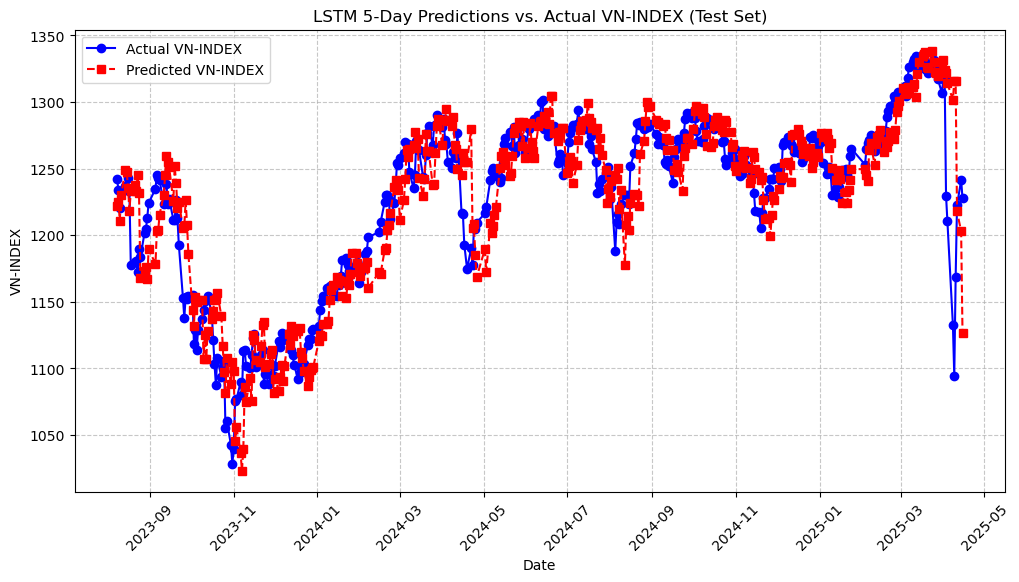

Predicted vs. Actual VN-INDEX (Test Set):
    Forecast_Date  Actual VN-INDEX  Predicted VN-INDEX
0      2023-08-08          1242.23         1222.210972
1      2023-08-09          1233.99         1225.097240
2      2023-08-10          1220.61         1211.027851
3      2023-08-11          1232.21         1230.046098
4      2023-08-14          1236.84         1249.249093
..            ...              ...                 ...
415    2025-04-09          1094.30         1316.091218
416    2025-04-10          1168.34         1316.072416
417    2025-04-11          1222.46         1217.898796
418    2025-04-14          1241.44         1202.968473
419    2025-04-15          1227.79         1126.671960

[420 rows x 3 columns]


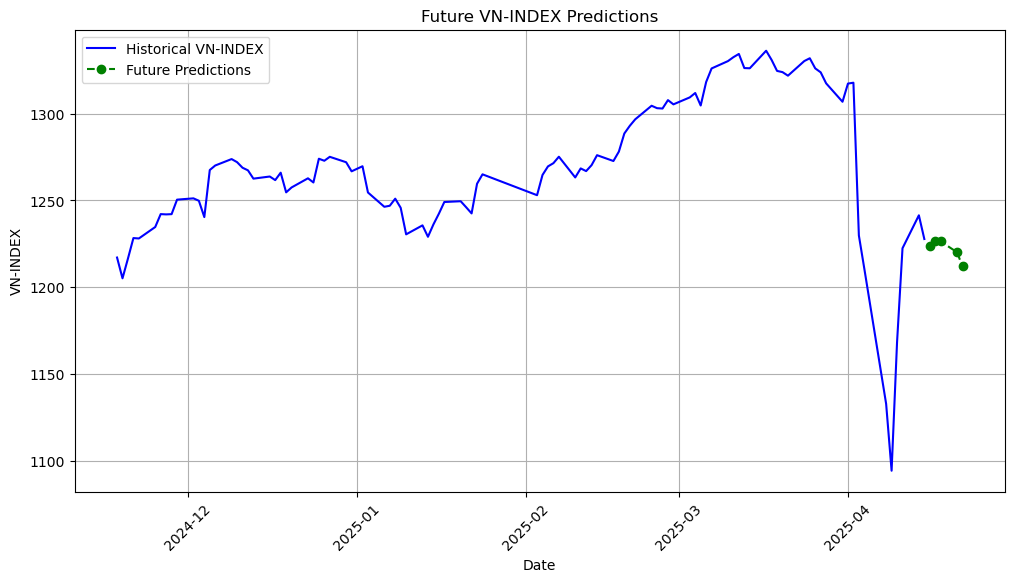

        Date  Predicted Price
0 2025-04-16      1223.730660
1 2025-04-17      1226.875213
2 2025-04-18      1226.381893
3 2025-04-21      1220.155767
4 2025-04-22      1212.000956


,Date,Predicted Price
0,2025-04-16,1223.730660
1,2025-04-17,1226.875213
2,2025-04-18,1226.381893
3,2025-04-21,1220.155767
4,2025-04-22,1212.000956


In [16]:
# 📊 Select only VN-INDEX for prediction
data = df_1["Change"]

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_1, tuning=False)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_1)

In [ ]:
# 📊 Select additional VN-INDEX statistics for prediction
data = df_1

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_1)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_1)

In [ ]:
# 📊 Select additional VN-INDEX statistics for prediction
data = lag_features_indicators(df_1[['Change']], ['Change'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_1)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_1)

In [ ]:
# 📊 Select additional VN-INDEX statistics for prediction
data = lag_features_indicators(df_1, ['Change'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_1)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_1)

In [ ]:
# 📊 Select additional VN-INDEX statistics for prediction
data = lag_features_indicators(df_1, df_1.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_1)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_1)

In [ ]:
# 📂 Load dataset
file_path_2 = "../ready_data/change_external.csv"
df_2 = pd.read_csv(file_path_2)
df_2 = quicky_data(df_2)

In [ ]:
data = df_2

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_2)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_2)

In [ ]:
data = lag_features_indicators(df_2, ['Change'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_2)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_2)

In [ ]:
data = lag_features_indicators(df_2, df_2.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_2)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_2)

In [ ]:
# 📂 Load dataset
file_path_3 = "../ready_data/change_merged.csv"
df_3 = pd.read_csv(file_path_3)
df_3 = quicky_data(df_3)

In [ ]:
data = df_3

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_3)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_3)

In [ ]:
data = lag_features_indicators(df_3, ['Change'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_3)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_3)

In [ ]:
data = lag_features_indicators(df_3, df_3.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_3)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_3)

In [ ]:
data = lag_features_indicators(df_3, df_1.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_3)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_3)

In [ ]:
data = lag_features_indicators(df_3, df_2.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, pred_close = lstm_model_pipeline(data, df_3, tuning=False, 
                                                               best_params={'hidden_size': 128, 'num_layers': 2, 'dropout': 0.11332901548913746, 'learning_rate': 0.0031320320734535903, 'batch_size': 64})

# 🔮 Generate future predictions
future_prediction(X_test_tensor, data, pred_close, scaler, model, num_days=5, df=df_3)